In [1]:
import sys

sys.path.append("..")

In [2]:
import json

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.datasets
import torchvision.transforms as T

import datasets
import metrics

/home/akors/.conda/envs/ml/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/akors/.conda/envs/ml/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you

# Dataset Metrics

Data set metrics like pixel counts per class, rgb mean/std, image size distribution are calculated in two steps.

The `metrics.DatasetMetricsFirstpass()` calculates most metrics except the standard deveation of the RGB values.

The `metrics.DatasetMetricsSecondpass()` requires previously calculated first pass results and calculates the standard
deviation of the RGB values.


## Data Loading

In [3]:
dataroot = '../data/'

In [4]:
import importlib
importlib.reload(metrics)

<module 'metrics' from '/home/akors/repos/akors/unet-test/nb/../metrics.py'>

In [5]:
year="2012"

In [6]:
ds_check = torchvision.datasets.VOCSegmentation(
    root=dataroot,
    year=year,
    image_set="trainval",
    #image_set="train",
    download=False,
    transform=T.ToTensor(), target_transform=T.PILToTensor())


In [7]:
ds_check[0][0].shape

torch.Size([3, 281, 500])

## First Pass

First pass calculates most metrics

### Single Sample

In [8]:
firstpass = metrics.DatasetMetricsFirstpass()

In [9]:
# single sample for testing
img, mask = ds_check[2]
firstpass.update(img, mask)

In [10]:
firstpass.calculate()

{'sample_count': 1,
 'rgb_mean': [0.5101040601730347, 0.5233184099197388, 0.4943293333053589],
 'height_mean': 375.0,
 'height_std': 0.0,
 'width_mean': 500.0,
 'width_std': 0.0,
 'class_pixels': {0: 154539, 20: 30031, 255: 2930},
 'class_objects': {0: 1, 20: 1, 255: 1},
 'pixel_count': 187500,
 'object_count': 3}

In [11]:
img.shape

torch.Size([3, 375, 500])

In [12]:
img.shape[-2] * img.shape[-1]

187500

In [13]:
mask.unique(return_counts=True)

(tensor([  0,  20, 255], dtype=torch.uint8), tensor([154539,  30031,   2930]))

In [14]:
torch.std_mean(img, dim=(-2,-1))

(tensor([0.1896, 0.1907, 0.2048]), tensor([0.5101, 0.5233, 0.4943]))

### Whole dataset

In [15]:
firstpass = metrics.DatasetMetricsFirstpass()

In [16]:
for sample in ds_check:
    firstpass.update(*sample)

In [17]:
dataset_metric_dict = firstpass.calculate()
dataset_metric_dict

{'sample_count': 2913,
 'rgb_mean': [0.4568465189887431, 0.44091867824707537, 0.4047057680605658],
 'height_mean': 384.6728458633711,
 'height_std': 63.5685314839425,
 'width_mean': 471.9289392378991,
 'width_std': 57.45974064982267,
 'class_pixels': {0: 361560627,
  1: 3704393,
  2: 1571148,
  3: 4384132,
  4: 2862913,
  5: 3438963,
  6: 8696374,
  7: 7088203,
  8: 12473466,
  9: 4975284,
  10: 5027769,
  11: 6246382,
  12: 9379340,
  13: 4925676,
  14: 5476081,
  15: 24995476,
  16: 2904902,
  17: 4187268,
  18: 7091464,
  19: 7903243,
  20: 4120989,
  255: 28568409},
 'class_objects': {0: 2903,
  1: 178,
  2: 144,
  3: 208,
  4: 150,
  5: 183,
  6: 152,
  7: 255,
  8: 250,
  9: 271,
  10: 135,
  11: 157,
  12: 249,
  13: 147,
  14: 157,
  15: 888,
  16: 167,
  17: 120,
  18: 183,
  19: 167,
  20: 157,
  255: 2913},
 'pixel_count': 521582502,
 'object_count': 10134}

In [18]:
# print accurate total pixel count
dataset_metric_dict['pixel_count']

521582502

In [19]:
# estimate pixel count from means
dataset_metric_dict['height_mean']*dataset_metric_dict['width_mean']*dataset_metric_dict['sample_count']

528820916.7209063

## Second pass

### Single Sample

In [20]:
secondpass = metrics.DatasetMetricsSecondpass(dataset_metric_dict)

In [21]:
secondpass.update(*ds_check[0], 0)

### Whole Dataset

In [22]:
for idx, sample in enumerate(ds_check):
    secondpass.update(*sample, idx)

In [23]:
secondpass_result = secondpass.calculate()
secondpass_result

{'rgb_std': [0.2712492735621932, 0.2684503630844764, 0.28438828894633245]}

## Complete Dataset Metrics

In [24]:
dataset_metric_dict.update(secondpass_result)

In [25]:
print(json.dumps(dataset_metric_dict, indent=4))

{
    "sample_count": 2913,
    "rgb_mean": [
        0.4568465189887431,
        0.44091867824707537,
        0.4047057680605658
    ],
    "height_mean": 384.6728458633711,
    "height_std": 63.5685314839425,
    "width_mean": 471.9289392378991,
    "width_std": 57.45974064982267,
    "class_pixels": {
        "0": 361560627,
        "1": 3704393,
        "2": 1571148,
        "3": 4384132,
        "4": 2862913,
        "5": 3438963,
        "6": 8696374,
        "7": 7088203,
        "8": 12473466,
        "9": 4975284,
        "10": 5027769,
        "11": 6246382,
        "12": 9379340,
        "13": 4925676,
        "14": 5476081,
        "15": 24995476,
        "16": 2904902,
        "17": 4187268,
        "18": 7091464,
        "19": 7903243,
        "20": 4120989,
        "255": 28568409
    },
    "class_objects": {
        "0": 2903,
        "1": 178,
        "2": 144,
        "3": 208,
        "4": 150,
        "5": 183,
        "6": 152,
        "7": 255,
        "8": 250,


### Class Balance

In [26]:
num_classpixels = dataset_metric_dict['class_pixels']

In [27]:
## uncomment thisremap unknown/difficult classes to background
#num_classpixels[0] += num_classpixels[255]
#del num_classpixels[255]

In [28]:
labels = [datasets.CLASSNAMES[idx] for idx in sorted(datasets.CLASSNAMES.keys())]
labels.append('void') # scary

In [29]:
classpixels_list = [num_classpixels[idx] for idx  in sorted(num_classpixels.keys())]

<BarContainer object of 22 artists>

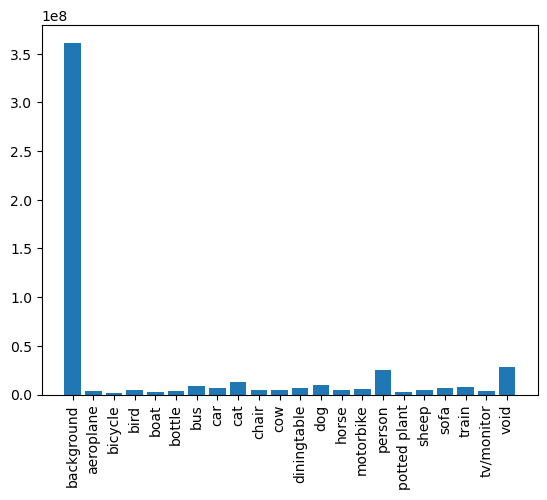

In [30]:
plt.xticks(rotation='vertical')
plt.bar(labels, classpixels_list)

<BarContainer object of 20 artists>

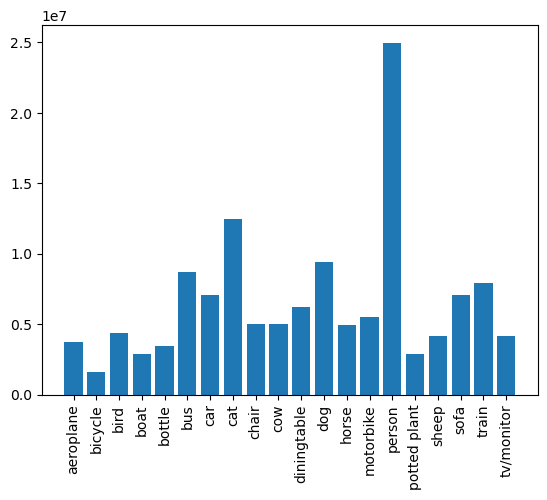

In [31]:
# leave out background/unknown class
plt.xticks(rotation='vertical')
plt.bar(labels[1:-1], classpixels_list[1:-1])

In [32]:
# ratio of background/void to actual classes
(classpixels_list[0]+classpixels_list[-1]) / sum(classpixels_list[1:-1])

2.967810951443456

## Loading Daset Stats

In [33]:
datasets.DATASET_STATS["2012"]

{'sample_count': 1464,
 'rgb_mean': [0.456797805118573, 0.4431319283728635, 0.4082984168812775],
 'rgb_std': [0.27287834297763963, 0.2693239723248675, 0.28497994197739135]}

In [34]:
years=["2011", "2012"]

In [35]:
datasets.get_dataset_mean_std(years)

/home/akors/repos/akors/unet-test/nb/../datasets.py:252: UserWarning: Precomputed stats for year 2011+2012 are no available. Resorting to weighted avarage over the years.
  warnings.warn("Precomputed stats for year " + combinedname + " are no available. "+\


(array([0.45549866, 0.4424667 , 0.40801557]),
 array([0.27235018, 0.2687922 , 0.28464218]))

In [36]:
datasets.get_dataset_mean_std([str(y) for y in range(2007, 2012+1)])

([0.45524269659916283, 0.44245909361169117, 0.40813989028331643],
 [0.272263535943418, 0.2686478121215398, 0.2844137407538725])

In [37]:
datasets.get_dataset_mean_std([str(y) for y in range(2009, 2012+1)])

/home/akors/repos/akors/unet-test/nb/../datasets.py:252: UserWarning: Precomputed stats for year 2009+2010+2011+2012 are no available. Resorting to weighted avarage over the years.
  warnings.warn("Precomputed stats for year " + combinedname + " are no available. "+\


(array([0.45575958, 0.4433678 , 0.40875627]),
 array([0.27218359, 0.26858449, 0.28463335]))